<a href="https://colab.research.google.com/github/Wachacha-jay/Computer_vision_Image_classification/blob/main/Data_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install torchinfo

In [2]:
import os
import sys
from collections import Counter

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

torch.backends.cudnn.deterministic = True

In [3]:
print("Platform:", sys.platform)
print("Python version:", sys.version)
print("---")
print("matplotlib version:", matplotlib.__version__)
print("pandas version:", pd.__version__)
print("PIL version:", PIL.__version__)
print("torch version:", torch.__version__)
print("torchvision version:", torchvision.__version__)

Platform: linux
Python version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
---
matplotlib version: 3.10.0
pandas version: 2.2.2
PIL version: 11.2.1
torch version: 2.6.0+cu124
torchvision version: 0.21.0+cu124


In [4]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cpu device.


In [5]:
!pip install kagglehub

# Upload your Kaggle API key (kaggle.json)
from google.colab import files
files.upload()  # Select your kaggle.json file

# Move the key to the correct directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [6]:
import kagglehub

# Download the dataset
path = kagglehub.dataset_download("srg9000/cassava-plant-disease-merged-20192020")

print("Path to dataset files:", path)  # This will show where the dataset is stored

100%|██████████| 10.7G/10.7G [01:44<00:00, 110MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/srg9000/cassava-plant-disease-merged-20192020/versions/3


In [7]:
import shutil
import os

# Copy the dataset to a new location
destination = "./cassava_dataset"
if not os.path.exists(destination):
    shutil.copytree(path, destination)
    print(f"Dataset copied to {destination}")
else:
    print(f"{destination} already exists")

Dataset copied to ./cassava_dataset


In [8]:
destination

'./cassava_dataset'

In [9]:
os.listdir(destination)

['train_images_tfrecords',
 'merged_train.csv',
 'train_images',
 'extraimages_tfrecords',
 'extra_images']

In [10]:
data_dir = os.path.join(destination, 'merged_train.csv')

In [11]:
import pandas as pd
df = pd.read_csv(data_dir)
df.head()

,image_id,labels
0,723977410.jpg,3
1,3193577634.jpg,1
2,3349107107.jpg,3
3,2933959901.jpg,0
4,3020460837.jpg,4


In [12]:
labels_dict = {
    0: 'Cassava Bacterial Blight (CBB)',
    1: 'Cassava Brown Streak Disease (CBSD)',
    2: 'Cassava Green Mottle (CGM)',
    3: 'Cassava Mosaic Disease (CMD)',
    4: 'Healthy'
}

# Add a new column 'disease_name' by mapping 'labels' to 'labels_dict'
df['disease_name'] = df['labels'].map(labels_dict)

# Display the updated DataFrame
df.head()

,image_id,labels,disease_name
0,723977410.jpg,3,Cassava Mosaic Disease (CMD)
1,3193577634.jpg,1,Cassava Brown Streak Disease (CBSD)
2,3349107107.jpg,3,Cassava Mosaic Disease (CMD)
3,2933959901.jpg,0,Cassava Bacterial Blight (CBB)
4,3020460837.jpg,4,Healthy


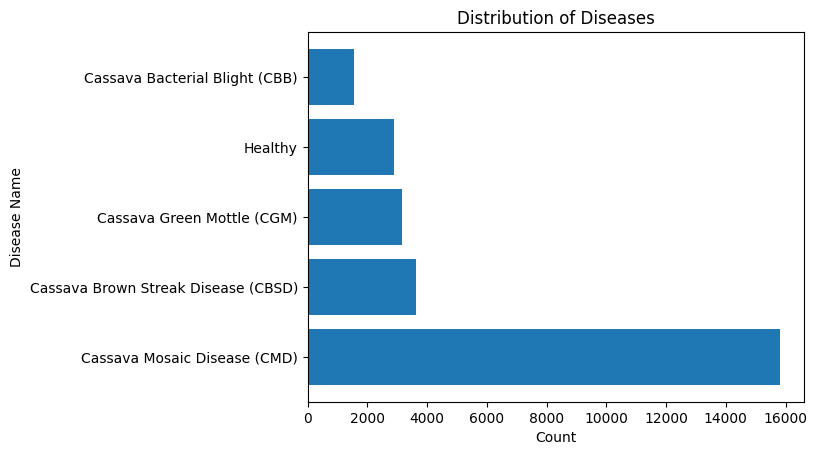

In [14]:
import matplotlib.pyplot as plt
# Get the counts of each disease
disease_counts = df['disease_name'].value_counts()
# Create a horizontal bar plot
plt.barh(disease_counts.index, disease_counts.values)
# Set the title and labels
plt.title('Distribution of Diseases')
plt.xlabel('Count')
plt.ylabel('Disease Name')
# Display the plot
plt.show()

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27053 entries, 0 to 27052
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   image_id      27053 non-null  object
 1   labels        27053 non-null  int64 
 2   disease_name  27053 non-null  object
dtypes: int64(1), object(2)
memory usage: 634.2+ KB


Lets now investigate the images will be using in our classification problem, we will get the path to the directory with the images, then rearrange the images using the labels and image names, we have obtained from the Dataframe, we will sort ot the images and copy the images with their correct labels to their subdirectories this will provide an easier way fro us while building our model.

In [15]:
train_path = os.path.join(destination, "train_images", "train_images")

In [16]:
import os
import shutil
import pandas as pd

# ===== CONFIGURATION =====
source_folder = train_path  # Folder containing all your images
destination_root = "train"        # Main folder to be created


# ===== FOLDER CREATION =====
# Create main folder and subfolders (with existence checks)
os.makedirs(destination_root, exist_ok=True)  # Main 'train' folder
print(f"✅ Created main folder: {destination_root}/")

for disease in labels_dict.values():
    subfolder = os.path.join(destination_root, disease)
    os.makedirs(subfolder, exist_ok=True)
    print(f"  ├── Created subfolder: {disease}/")

# ===== IMAGE ORGANIZATION =====
success_count = 0
missing_count = 0

for _, row in df.iterrows():
    src = os.path.join(source_folder, row['image_id'])
    dest = os.path.join(destination_root, labels_dict[row['labels']], row['image_id'])

    try:
        shutil.copy2(src, dest)  # copy2 preserves metadata
        success_count += 1
    except FileNotFoundError:
        print(f"⚠️ Missing: {row['image_id']}")
        missing_count += 1
    except Exception as e:
        print(f"❌ Error copying {row['image_id']}: {str(e)}")

# ===== RESULTS SUMMARY =====
print("\n📊 Organization Complete!")
print(f"✅ Successfully copied: {success_count} files")
print(f"⚠️  Missing files: {missing_count}")
print(f"📁 Final structure in: {os.path.abspath(destination_root)}/")

✅ Created main folder: train/
  ├── Created subfolder: Cassava Bacterial Blight (CBB)/
  ├── Created subfolder: Cassava Brown Streak Disease (CBSD)/
  ├── Created subfolder: Cassava Green Mottle (CGM)/
  ├── Created subfolder: Cassava Mosaic Disease (CMD)/
  ├── Created subfolder: Healthy/

📊 Organization Complete!
✅ Successfully copied: 27053 files
⚠️  Missing files: 0
📁 Final structure in: /content/train/


In [17]:
classes = os.listdir("/content/train")

In [18]:
classes

['Cassava Green Mottle (CGM)',
 'Healthy',
 'Cassava Mosaic Disease (CMD)',
 'Cassava Bacterial Blight (CBB)',
 'Cassava Brown Streak Disease (CBSD)']

In [41]:
#Lets confirm we have all the images by counting through the subfolder
from pathlib import Path
class_paths = [os.path.join("/content/train", cls) for cls in classes]
class_paths

['/content/train/Cassava Green Mottle (CGM)',
 '/content/train/Healthy',
 '/content/train/Cassava Mosaic Disease (CMD)',
 '/content/train/Cassava Bacterial Blight (CBB)',
 '/content/train/Cassava Brown Streak Disease (CBSD)']

In [42]:
destination_root = Path("/content/train")

In [45]:
os.listdir(destination_root)

['.git',
 'Cassava Green Mottle (CGM)',
 'Healthy',
 'Cassava Mosaic Disease (CMD)',
 'Cassava Bacterial Blight (CBB)',
 'Cassava Brown Streak Disease (CBSD)']

In [48]:
destination_root.iterdir()

<generator object Path.iterdir at 0x7934c5b96340>

In [49]:
!git config --global user.email "jameswachacha@gmail.com"
!git config --global user.name "Wachacha-jay"

In [50]:
import os

# Change the current directory to the destination_root
os.chdir(destination_root)

# Initialize a Git repository
!git init

# Add all files to the staging area
!git add .

# Commit the added files
!git commit -m "Add cassava dataset train images"

Streaming output truncated to the last 5000 lines.
 create mode 100644 Cassava Mosaic Disease (CMD)/train-cmd-1494.jpg
 create mode 100644 Cassava Mosaic Disease (CMD)/train-cmd-1495.jpg
 create mode 100644 Cassava Mosaic Disease (CMD)/train-cmd-1496.jpg
 create mode 100644 Cassava Mosaic Disease (CMD)/train-cmd-1497.jpg
 create mode 100644 Cassava Mosaic Disease (CMD)/train-cmd-1498.jpg
 create mode 100644 Cassava Mosaic Disease (CMD)/train-cmd-1499.jpg
 create mode 100644 Cassava Mosaic Disease (CMD)/train-cmd-15.jpg
 create mode 100644 Cassava Mosaic Disease (CMD)/train-cmd-150.jpg
 create mode 100644 Cassava Mosaic Disease (CMD)/train-cmd-1500.jpg
 create mode 100644 Cassava Mosaic Disease (CMD)/train-cmd-1501.jpg
 create mode 100644 Cassava Mosaic Disease (CMD)/train-cmd-1502.jpg
 create mode 100644 Cassava Mosaic Disease (CMD)/train-cmd-1503.jpg
 create mode 100644 Cassava Mosaic Disease (CMD)/train-cmd-1504.jpg
 create mode 100644 Cassava Mosaic Disease (CMD)/train-cmd-1505.jpg
